In [1]:
import csv
import matplotlib.pyplot as plt

In [2]:
class Series(list):
    def __init__(self, values=[]):
        super().__init__()
        self.extend(values)
    
    def __ge__(self, other):
        res = Series()
        for e in self:
            res.append(e >= other)
        return res

In [58]:
class DataFrame:
    @staticmethod
    def read_csv(filename):
        df = DataFrame()
        with open(filename) as csvfile:
            heart = csv.reader(csvfile, delimiter=',')

            df.columns = next(heart)
            ncols = len(df.columns)

            df.data = [Series() for _ in range(ncols)]
            for row in heart:
                #print(row)
                for i in range(ncols):
                    val = int(row[i])
                    df.data[i].append(val)
        return df

    def __init__(self, data=None, columns=None):
        self.columns = []
        self.data = []
        if columns is not None:
            self.columns = columns
            self.data = [Series() for _ in columns]
        if data is not None:
            self.data = data
    
    def __getitem__(self, key):
        if type(key) is str:
            # якщо key це str, то повернути колонку
            try:
                i = self.columns.index(key)
                return self.data[i]
            except ValueError:
                raise KeyError(f'No column {key}')
        elif hasattr(key, '__iter__'):
            # якщо key це iterable and not str, то фільтрувати
            res = DataFrame(columns=self.columns)
            for i in range(len(key)):
                if key[i] == True:
                    for j in range(len(res.columns)):
                        res.data[j].append(self.data[j][i])
            return res
        else:
            raise KeyError(f'Cannot index by {key}')
        
    
    def __setitem__(self, col, data):
        try:
            i = self.columns.index(col)
            self.data[i] = data
        except ValueError:   
            # створити нову
            self.columns.append(col)
            self.data.append(data)
            
    def __getattr__(self, item):
        if item in self.columns:
            return self[item]
            
    def __len__(self):
        if not self.columns:
            return 0
        return len(self.data[0])
    
    @property
    def shape(self):
        return (len(df.columns), len(self))
    
    def apply(self, func, axis=0):
        res = Series()
        if axis == 0:
            for i, col in enumerate(self.columns):
                r = func(self.data[i])
                res.append(r)
        elif axis == 1:
            for i in range(len(self)):
                args = Series()
                for j in range(len(self.columns)):
                    args.append(self.data[j][i])
                r = func(args)
                res.append(r)
        return res

In [38]:
df = DataFrame.read_csv("./heart.csv")

print(df.columns)
print(len(df))

['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh']
303


In [89]:
print(df.trtbps[:10])

[145, 130, 130, 120, 120, 140, 140, 120, 172, 150]


In [40]:
print(len(df))
print(sum(df.trtbps >= 140))

303
97


In [61]:
df1 = df[df.trtbps >= 140]   

len(df1)

97

In [63]:
def label_by_range(ranges, df, col):
    def inner(row):
        iage = df.columns.index(col)
        age = row[iage]
        for minage, maxage, label in ranges:
            if age in range(minage, maxage):
                return label
        raise ValueError(f'Cannot label age={age}')
    return inner

ranges = [
    (25, 35, '25-34'),
    (35, 45, '35-44'),
    (45, 55, '45-54'),
    (55, 65, '55-64'),
    (65, 75, '65-74'),
    (75, 85, '75-84')
]
df1['age_group'] = df1.apply(label_by_range(ranges, df1, 'age'), axis=1)

In [69]:
h_rate_by_group = {}

for i in range(len(df1)):
    age_group = df1['age_group'][i]
    hrate = df1['thalachh'][i]
    if age_group not in h_rate_by_group:
        h_rate_by_group[age_group] = [0.0, 0.0]
    h_rate_by_group[age_group][0] += hrate
    h_rate_by_group[age_group][1] += 1
    
for age_group in h_rate_by_group:
    hrsum, hrlen = h_rate_by_group[age_group]
    h_rate_by_group[age_group] = hrsum/hrlen

h_rate_by_group

{'55-64': 144.71428571428572,
 '45-54': 152.78947368421052,
 '65-74': 140.47619047619048,
 '35-44': 178.28571428571428,
 '75-84': 116.0}

<BarContainer object of 5 artists>

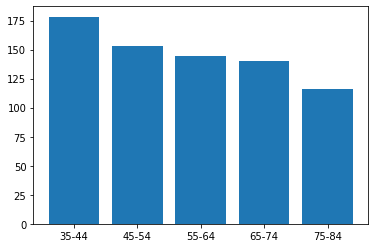

In [88]:
x, y = zip(*sorted(list(h_rate_by_group.items())))


plt.bar(x, y)

## Cross-checking with Pandas

In [74]:
import numpy as np
import pandas as pd

In [75]:
df_pd = pd.read_csv("./heart.csv")

In [76]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       303 non-null    int64
 1   sex       303 non-null    int64
 2   cp        303 non-null    int64
 3   trtbps    303 non-null    int64
 4   chol      303 non-null    int64
 5   fbs       303 non-null    int64
 6   restecg   303 non-null    int64
 7   thalachh  303 non-null    int64
dtypes: int64(8)
memory usage: 19.1 KB


In [77]:
df1 = df_pd[df_pd['trtbps'] >= 140]

In [78]:
df1.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh
0,63,1,3,145,233,1,0,150
5,57,1,0,140,192,0,1,148
6,56,0,1,140,294,0,0,153
8,52,1,2,172,199,1,1,162
9,57,1,2,150,168,0,1,174


In [79]:
bins = [25, 35, 45, 55, 65, 75, 84]
labels = ['25-34', '35-44', '45-54', '55-64', '65-74', '75-84']

df1['age_group'] = pd.cut(df1['age'], bins=bins, labels=labels, right=False)

/home/qgelena/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [84]:
df_pd[df_pd.age.isin(range(25, 35))]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh
58,34,1,3,118,182,0,0,174
72,29,1,1,130,204,0,0,202
125,34,0,1,118,210,0,1,192


<BarContainer object of 6 artists>

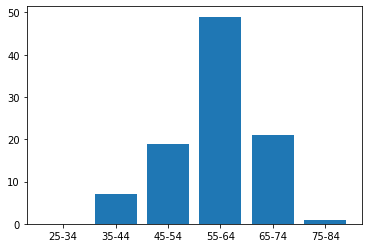

In [21]:
g1 = df1.groupby(["age_group"]).size().reset_index(name='count')

y= g1['count']
x=g1['age_group']

plt.bar(x, y)

In [22]:
#df1.groupby('age_group', as_index=False)['thalachh'].mean()
g1 = df1.groupby('age_group')['thalachh'].mean().reset_index(name='mean_thalachh')

In [23]:
g1

,age_group,mean_thalachh
0,25-34,NaN
1,35-44,178.285714
2,45-54,152.789474
3,55-64,144.714286
4,65-74,140.476190
5,75-84,116.000000


<BarContainer object of 6 artists>

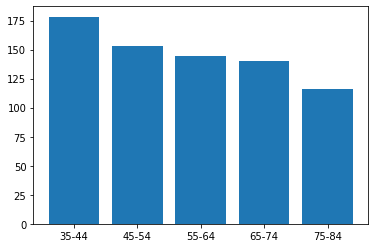

In [24]:
y= g1['mean_thalachh']
x=g1['age_group']

plt.bar(x, y)

In [25]:
df1[df1["age_group"] == '25-34']

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,age_group
